This notebook coontains code to assess goodness of fit of the SISTR2 motif analysis (a,b) scores

In [1]:
%pylab inline
import sys
sys.path.append("/gymreklab-tscc/bonnieh/helper_functions")
from Joint_method_functions import *
import glob
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.ticker as ticker
import seaborn as sns
from statistics import mode
from scipy import stats

PLOTDIR = '/storage/BonnieH/selection_project/figures/supp_figures/'

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Given file, get ABC lookup table
def getABCTable(file):
    num_bins = 0
    
    # Return list of lists that contain [s, het, common]
    table = GetABCList(file, num_bins)
    dic_summ_stats = {}
        
    # Fill in dic_summ_stats: Key is s, value is list of het, number of common alleles pairs for given s value
    for combo in table:
        s_round = get_LRT_bin(combo[0])
        if s_round not in dic_summ_stats:
            dic_summ_stats[s_round] = []
        dic_summ_stats[s_round].append([combo[1], combo[2]]) # Append het, number of common alleles for s value
    
    return dic_summ_stats

In [9]:
# Different colormap options: 'binary', 'hot_r', 'Blues', 'YlGnBu', 'Greens', 'viridis', 'cool'
def main():
    
    pval_threshold = 0.05
    goodness_of_fit_file = open('goodness_of_fit_motif_analysis.txt','w')
    
    #print('Running main')
    combos = [(2, 'intergenic'),(3, 'intergenic'),(4, 'intergenic')]
    superfolder = 'results_top_x'
    subfolder = 'motif_analysis_diff_mu_071921'
    colormap = 'Greens'
    
    num_files_dict = {} # Key: Period, Value: Number of files
    num_files_dict[2] = 30
    num_files_dict[3] = 72
    num_files_dict[4] = 36
    
    opt_dic = {}
    opt_dic[2] = ['11','12','13','14','15','16','17','18','19','20']
    opt_dic[3] = ['05','06','07','08','09','10','11','12','13']
    opt_dic[4] = ['07','08','09','10']
    
    motif_dic = {}
    motif_dic[2] = ['AT','AG','AC']
    motif_dic[3] = ['AAT','ATC','AAG','AGG','AGC','CCG','AAC','ACC'] 
    motif_dic[4] = ['AAAT','AATC','AATG','ATCC','AAAG','AAGG','AGAT','AAAC','ACAT']
    
    file_name_dic = {}
    file_name_dic[2] = 'dinuc'
    file_name_dic[3] = 'trinuc'
    file_name_dic[4] = 'tetranuc'
    
    for combo in combos:
        
        per = combo[0]
        list_of_percents = []
        list_of_num_loci = []
        list_of_pvalue= []

        # Plot heatmap for each motif in given period
        for i in range(0,1):
            for motif in motif_dic[per]:
                for opt in opt_dic[per]:
                    file_list = glob.glob('/gymreklab-tscc/bonnieh/joint_method/%s/%s/per_%d_*%s*opt_%s.txt'%(superfolder, subfolder, per, motif, opt))
                    
                    if 1>0:
                        filename = file_list[0]
                        results_file = open(filename, 'r')
                        
                        for k in range(0, 2):
                            line= results_file.readline()
                        
                        info = line.strip().split(': ')
                        num_loci = info[1]
                        num_loci = num_loci.strip().split(' ')
                        num_loci = int(num_loci[0])
                        
                        list_of_num_loci.append(num_loci)
                        
                        if num_loci == 0:
                            
                            for elem in mut_setting_dic[per]:
                                list_of_percents.append(0)
                                list_of_pvalue.append(0)
                        
                        else:
                            
                            if opt[0] == '0':
                                opt_num=int(opt[1]) 
                            else:
                                opt_num=int(opt)

                            header = results_file.readline().strip().split('\t')
                            info = results_file.readline().strip().split(': ')

                            list_het = info[1]
                            list_het = list_het[1:]
                            list_het = list_het[:-1]
                            het_list = list_het.strip().split(', ')

                            obs_het_distr = []
                            opt_allele_sub_list = []
                            for elem in het_list:
                                obs_het_distr.append(float(elem))
                                opt_allele_sub_list.append((per, opt_num))

                            for k in range(0, 3):
                                line= results_file.readline()
                                
                            info = line.strip().split(',')
                            a_val = float(info[0])
                            b_val = float(info[1])
                            #print('a val')
                            #print(a_val)
                            #print('b val')
                            #print(b_val)
                            
                            #print((motif,opt))
                            mode_setting = filename.split('_')
                            #print(mode_setting)
                            mode_setting = mode_setting[13]
                            #print('mode setting')
                            #print(mode_setting)
                                
                            goodness_of_fit_file.write(motif + '\t' + str(opt_num) + '\t' + mode_setting + '\n')
                            #obs_het_distr, opt_allele_sub_list = GetObsHetDistrFn(motif, opt_num)
                            
                            # Get simulated heterozygosity
                            
                            mut_setting_folder_name = {}
                            mut_setting_folder_name[2] = 'eurodem_prior2_dinuc_'
                            mut_setting_folder_name[3] = 'eurodem_prior2_trinuc_'
                            mut_setting_folder_name[4] = 'eurodem_prior2_tetranuc_'

                            folder_prefix = mut_setting_folder_name[len(motif)]
                            
                            file = '/gymreklab-tscc/bonnieh/abc/results/' + folder_prefix + mode_setting + '_1kg_euro/' + str(len(motif)) + '_' + str(opt_num) + '.txt'

                            ABC_dic = {}
                            ABC_dic[opt_num] = getABCTable(file)
                            
                            ABC_tables_mut = ABC_dic
                            count = 0
                            for zz in range(0, 100):
                                sim_het_list, sim_common_list = GetLists(ABC_tables_mut, opt_allele_sub_list, a_val, b_val)
                                if len(obs_het_distr) != len(sim_het_list):
                                    print('Observed and simulated het different lengths')
                                ks_stat, pval = stats.ks_2samp(obs_het_distr, sim_het_list)
                                if pval > pval_threshold:
                                    count = count + 1
                                #if pval < 0.05:
                                    #list_of_pvalue.append(0)
                                #else:
                                    #list_of_pvalue.append(1)
                            list_of_pvalue.append(count)
                            print("%s\t%s\t%s"%(motif, opt, count))
                            #print(count)
                            
                        results_file.close()
        matrix = np.zeros((len(motif_dic[per]), len(opt_dic[per])))
        #print(matrix)
        counter = 0

        for i in range(len(motif_dic[per])): 
            for j in range(len(opt_dic[per])):
                #print(i,j)
                matrix[i,j] = list_of_pvalue[counter]
                counter = counter + 1

        # Visualize heatmap

        #print(matrix)
      
        opt = []
        
        for opt_num in opt_dic[per]:
            if opt_num[0] == '0':
                opt.append(opt_num[1]) 
            else:
                opt.append(opt_num)

        print(matrix)

        fig, ax = plt.subplots()
        
        im = ax.imshow(matrix,cmap=colormap) 
        cbar = fig.colorbar(im)
        cbar.ax.set_ylabel('Percent simulations with good fit')

        # Show all ticks
        ax.set_xticks(np.arange(len(opt)))
        ax.set_yticks(np.arange(len(motif_dic[per])))

        # Label ticks
        ax.set_xticklabels(opt)
        ax.set_yticklabels(motif_dic[per])

        if per == 2:
            ax.set_title('Dinucleotides',fontsize=20)
        if per == 3:
            ax.set_title('Trinucleotides',fontsize=20)
        if per == 4:
            ax.set_title('Tetranucleotides',fontsize=20)
        
        plt.savefig('pdfs/heatmap_%d_w_cbar.pdf'%(per),bbox_inches='tight')
        plt.yticks(size=15)
        plt.xticks(size=15)
        fig.tight_layout()

    goodness_of_fit_file.close()

AT	11	96
AT	12	25
AT	13	3
AT	14	0
AT	15	7
AT	16	23
AT	17	58
AT	18	96
AT	19	76
AT	20	100
AG	11	0
AG	12	98
AG	13	44
AG	14	98
AG	15	74
AG	16	99
AG	17	93
AG	18	98
AG	19	97
AG	20	99
AC	11	66
AC	12	96
AC	13	98
AC	14	54
AC	15	80
AC	16	97
AC	17	99
AC	18	78
AC	19	1
AC	20	0
[[ 96.  25.   3.   0.   7.  23.  58.  96.  76. 100.]
 [  0.  98.  44.  98.  74.  99.  93.  98.  97.  99.]
 [ 66.  96.  98.  54.  80.  97.  99.  78.   1.   0.]]
AAT	05	0
AAT	06	0
AAT	07	0
AAT	08	0
AAT	09	0
AAT	10	0
AAT	11	0
AAT	12	0
AAT	13	0
ATC	05	0
ATC	06	0
ATC	07	18
ATC	08	98
ATC	09	96
ATC	10	100
ATC	11	99
ATC	12	58
ATC	13	100
AAG	05	51
AAG	06	18
AAG	07	0
AAG	08	28
AAG	09	82
AAG	10	83
AAG	11	100
AAG	12	71
AAG	13	100
AGG	05	0
AGG	06	0
AGG	07	82
AGG	08	98
AGG	09	99
AGG	10	99
AGG	11	97
AGG	12	94
AGG	13	84
AGC	05	0
AGC	06	0
AGC	07	27
AGC	08	54
AGC	09	97
AGC	10	98
AGC	11	97
AGC	12	100
AGC	13	100
CCG	05	63
CCG	06	0
CCG	07	3
CCG	08	17
CCG	09	100
CCG	10	98
CCG	11	100
CCG	12	94
CCG	13	100
AAC	05	44
AAC	06	0
AAC	07	0
AAC	08	0
AAC	09	

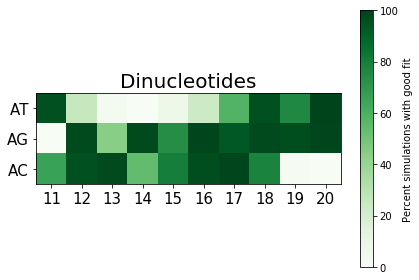

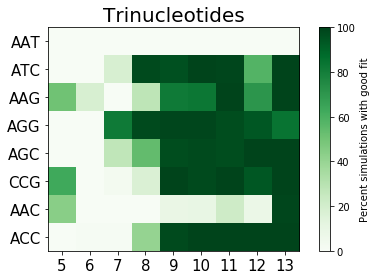

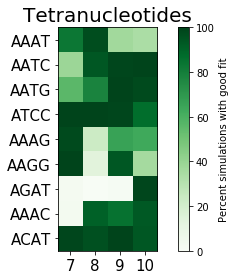

In [10]:
%%time
if __name__ == '__main__':
    main()